# TP 1 - Reinforcement Learning (November 16rd)

Name : Dorin Doncenco

### Instructions
This assignement will be a discovery of a library for working with RL problems,   an implementation of Policy Iteration and Value Iteration algorithm and the first implementation of a sampling-based algorithm.

We used the Cliff Walking Environment (also from Sutton's book).

    Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center
    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.

(https://gymnasium.farama.org/_images/cliff_walking.gif "Cliff Walking")

- Save this notebook in a ```.ipynb``` format and send it to cyriaque.rousselot(at)inria(dot)fr with the name ```TP1_NAME_SURNAME``` before November 23th.
- Make sure to comment your code and explain your decisions clearly. Write explanations in text if necessary 
- Answers must be short and precise and don't require thousands lines of code. 
- Generally, the code to complete is indicated with the comment ```#TO IMPLEMENT```
Good luck !


## A gentle start with Gymnasium

Have a look at the documentation of gymnasium https://gymnasium.farama.org/content/basic_usage/, of environments https://gymnasium.farama.org/api/env/ and of the Cliff Walking Environment https://gymnasium.farama.org/environments/toy_text/cliff_walking/. 


> You can use multiple render_mode in a gym environment class. For simplicity, I will ask you to render the environment in ansi mode to display it in the notebook.

**Q.1 Display the Action Space / State space of the CliffWalking environment**

In [1]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 0 ns (started: 2023-11-19 11:16:42 +01:00)


In [2]:
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt
import time 

print("="*10 + "Load the environment"+"="*10)
env = gym.make('CliffWalking-v0', render_mode="ansi") # Initialize the environment object
observation, info = env.reset(seed=42) # Reset the environment

print("="*10 + "Visualize the environment"+"="*10)
print(env.render()) # The Cliff Walking Environment in ANSI 

## Action Space
nb_actions = 4
print("="*10 + "Action Space"+"="*10)
action_space = env.action_space
print(action_space)

## State space
nb_states = 48
print("="*10 + "State Space"+"="*10)
state_space = env.observation_space
print(state_space)

env.close()

==========Load the environment==========
==========Visualize the environment==========
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


==========Action Space==========
Discrete(4)
==========State Space==========
Discrete(48)
time: 1.05 s (started: 2023-11-19 11:16:43 +01:00)


### Use of a random policy

**Q.2 Implement a policy that chose an action randomly from the action space and a policy that chose always the action "go right"**

In [3]:
def RandomPolicy(state,action_space):
    #select random from action_space
    return action_space.sample()
    
def GoRightPolicy(state,action_space):
    #select right action, according to docs the action_space = [up,right,down,left]
    return 1

def GoUpPolicy(state,action_space):
    #select up action, according to docs the action_space = [up,right,down,left]
    return 0

time: 0 ns (started: 2023-11-19 11:16:45 +01:00)


**Q.3 What is the meaning of the ouptut of the method ```step()``` of the environment class ?**

In [4]:
env = gym.make('CliffWalking-v0',render_mode="ansi")
env.reset()
print(env.step(2))
env.close()

(36, -1, False, False, {'prob': 1.0})
time: 0 ns (started: 2023-11-19 11:16:47 +01:00)


In [5]:
env.step(0)

(24, -1, False, False, {'prob': 1.0})

time: 0 ns (started: 2023-11-19 11:16:47 +01:00)


**A:** The output of the step method is the resulting state, the reward for that state, whether the state is terminal, whether the time limit is passed, and the transition probability.

**Q.4 Build a function ```transition(env,s1,Pi)``` that take in entry the environment, a state and a ```policy(state,action_space)``` function. It has to return the immediate reward ,the next state and a boolean that indicates if the next step is a terminal state.**

In [6]:
def transition(env,s1,Pi):
    # take in environment, state, and policy, and return reward, next state, and bool of terminal state
    action = Pi(s1,env.action_space)
    state, reward, done, _, _ = env.step(action)

    return reward, state, done

env= gym.make('CliffWalking-v0',render_mode='ansi')
s0 = env.reset()[0]
print(transition(env,s0,RandomPolicy)) 
env.close()

(-1, 36, False)
time: 0 ns (started: 2023-11-19 11:16:49 +01:00)


In [7]:
# do some policy 10 times
env = gym.make('CliffWalking-v0',render_mode='ansi')
s0 = env.reset()[0]
for i in range(10):
    print(transition(env,s0,GoUpPolicy))
env.close()


(-1, 24, False)
(-1, 12, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
time: 0 ns (started: 2023-11-19 11:16:49 +01:00)


**Q.5 Build a function ```SimulateTrajectory(T,policy)``` that simulate the behavior of an agent that start at an initial state, chose its next states using ```policy(state,action_space)``` function and keep trace of the state visited and the rewards obtained. It stops after ```T``` steps or if it encounters a terminal state. Use this function to plot the Cumulated Discounted Reward for multiple initialisations**
>(Hint: you can use the function defined in question Q.4)

$ \frac{log(\frac{1}{(10^{-3}*(1-\gamma))})}{log(\frac{1}{\gamma})} $

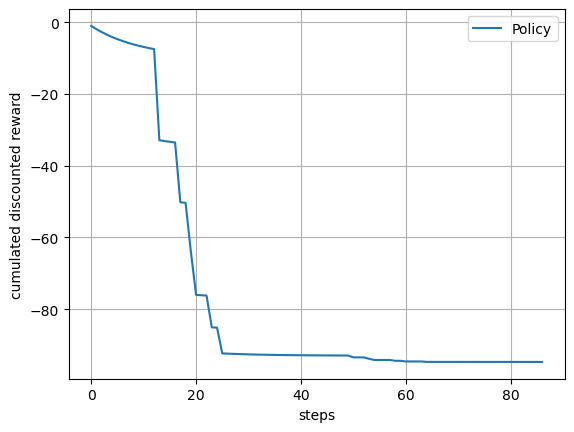

time: 219 ms (started: 2023-11-19 11:16:50 +01:00)


In [8]:
def SimulateTrajectory(T,policy):
    """return a vector of T successive states and a vector of T successive immediate rewards"""
    env = gym.make('CliffWalking-v0',render_mode='ansi')
    s0 = env.reset()[0]
    states = [s0]
    rewards = []
    for t in range(T):
        r,s,done = transition(env,states[-1],policy)
        states.append(s)
        rewards.append(r)
        if done:
            break
    env.close()
    return states,rewards

gamma = 0.9 # discount factor 
T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) # truncation of the infinite sum 
States1,Rewards1 = SimulateTrajectory(T, RandomPolicy)

# Plot cumulative discounted reward (on a single run):
plt.figure()
plt.plot(np.cumsum(Rewards1*np.array([gamma**t for t in range(T)])),label="Policy")

plt.xlabel('steps')
plt.ylabel('cumulated discounted reward')
plt.legend()
plt.grid()
plt.show()


**Q.6 Implement the optimal policy and display a corresponding trajectory from the initial state.**

In [9]:
def OptimalPolicy(state, action_space):
    if state==36:
        return 0
    elif state in [11, 23, 35]:
        return 2
    else:
        return 1

time: 0 ns (started: 2023-11-19 11:16:51 +01:00)


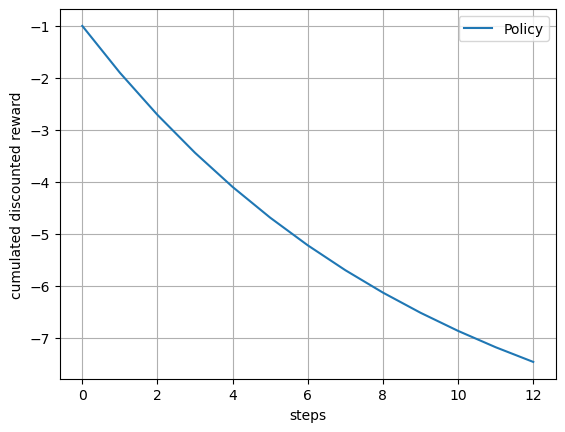

time: 125 ms (started: 2023-11-19 11:16:52 +01:00)


In [10]:
States1,Rewards1 = SimulateTrajectory(T, OptimalPolicy)

# Plot cumulative discounted reward (on a single run):
plt.figure()
plt.plot(np.cumsum(Rewards1*np.array([gamma**t for t in range(len(States1)-1)])),label="Policy")

plt.xlabel('steps')
plt.ylabel('cumulated discounted reward')
plt.legend()
plt.grid()
plt.show()

# Dynamic Programming

In order to use our dynamic programming algorithms, we need to know the parameters of the MDP. 
Here we know the reward and transition model. 

**Q.7 Fill the reward array ```r[s,a]```, the transition array ```p[s,a,s']``` and the terminal array ```T[s]``` that return a boolean if the state is terminal.**


> Hint : You can look at https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py

In [11]:
# Can be useful 
def number_to_grid(x): # Convert a state number into its coordinates on the grid.
    return(np.unravel_index(np.array(x),shape=(4,12)))

def grid_to_number(x):
    return(np.ravel_multi_index(x,(4,12)))


# MDP parameters
nb_states = 48
nb_actions = 4
P = np.zeros((nb_states,nb_actions,nb_states)) # P[s,a,s'] = p(s' | s,a) 
r = np.zeros((nb_states,nb_actions)) # r[s,a] =  reward received in state s when playing action a
T = np.zeros(nb_states,dtype=bool) # T[s] = True if s is a terminal state
# Fill P and r
env = gym.make('CliffWalking-v0',render_mode='ansi')
for s in range(nb_states):
    for a in range(nb_actions):
        for prob, next_state, reward, done in env.P[s][a]:
            P[s,a,next_state] = prob
            r[s,a] = reward
            T[s] = done

# set the rewards for getting into the final state and any action from the final state to 0
r[35][2] = 0
r[47][0] = 0
r[47][1] = 0
r[47][2] = 0
r[47][3] = 0

time: 16 ms (started: 2023-11-19 11:16:54 +01:00)


c:\Users\deus-diabolus\miniconda3\envs\uni_env\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


In [12]:
def sample_next_state(P,s,a): # sampling method for next state given current state and action
    return np.random.choice(range(nb_states), 1, p=P[s,a])[0]

time: 0 ns (started: 2023-11-19 11:16:54 +01:00)


### Policy Iteration

In this section, we will consider deterministic policies. A deterministic policy  is represented as a vector pi[s] with s a state. 

In [13]:
example_pi_actions =  np.random.choice([0,1,2,3], nb_states)  # An example of random deterministic policy
example_pi = np.zeros((nb_states,nb_actions))
for s in range(nb_states):
    example_pi[s,example_pi_actions[s]] = 1.0

time: 0 ns (started: 2023-11-19 11:16:55 +01:00)


In [14]:
# pi[s][a] = probability of taking action a in state s
optimal_pi = np.zeros((nb_states,nb_actions))
for s in range(nb_states):
    optimal_pi[s,OptimalPolicy(s,env.action_space)] = 1

time: 0 ns (started: 2023-11-19 11:16:55 +01:00)


In [15]:
state = 13
print(f"The action from state {state} is {example_pi[state]}")

The action from state 13 is [0. 0. 0. 1.]
time: 0 ns (started: 2023-11-19 11:16:56 +01:00)


**Q.8 Using the Bellman equations, build a function for evaluating the state-value function $V_\pi$ of a policy $\pi$ iteratively. We consider convergence with $\epsilon = 0.01$ or if we performed a maximum of 10000 iterations.**
> Hint : you can look at Sutton & Barto , Reinforcement Learning, An introduction, chapter 4

In [16]:
epsilon = 0.01
max_iter = 10000
def policy_evaluation(policy, epsilon, gamma, max_iter):
    V = np.zeros(nb_states) # intialize Values
    for i in range(max_iter):
        V_new = np.zeros(nb_states)
        for s in range(nb_states):
            for a in range(nb_actions):
                V_new[s] += policy[s][a] * P[s,a,:] @ (r[s,a] + gamma * V)
        if np.max(np.abs(V_new - V)) < epsilon:
            break
        V = V_new
    return V
    

time: 0 ns (started: 2023-11-19 11:16:57 +01:00)


In [17]:
# compute the value function of the random policy
V = policy_evaluation(example_pi, epsilon, gamma, max_iter)
print(V)

[  -9.90302263   -9.90302263  -90.09302263   -9.90302263   -9.90302263
   -9.90302263   -9.90302263   -9.90302263   -9.90302263   -9.90302263
   -9.90302263   -9.90302263   -9.90302263   -9.90302263  -99.00302263
   -9.90302263   -9.90302263   -9.90302263   -9.90302263  -90.09302263
  -99.00302263   -9.90302263   -9.90302263   -9.90302263   -9.90302263
   -9.90302263 -108.90302263 -108.90302263 -108.90302263 -108.90302263
   -9.90302263  -82.07402263 -108.90302263   -9.90302263 -108.90302263
  -99.00302263   -9.90302263 -108.90302263 -108.90302263 -108.90302263
  -99.00302263 -108.90302263 -108.90302263 -108.90302263 -108.90302263
   -9.90302263 -108.90302263   -8.90302263]
time: 47 ms (started: 2023-11-19 11:16:58 +01:00)


**Q.9 Build a policy improvement function**

In [18]:
def policy_improve(V, gamma):
    Q = np.zeros((nb_states,nb_actions))
    for s in range(nb_states):
        for a in range(nb_actions):
            Q[s,a] = P[s,a,:] @ (r[s,a] + gamma * V)
    new_policy = np.zeros((nb_states,nb_actions))
    new_policy[np.arange(nb_states),np.argmax(Q,axis=1)] = 1
    return new_policy
    

time: 0 ns (started: 2023-11-19 11:16:58 +01:00)


In [19]:
# compute the value function of the random policy
V = policy_evaluation(example_pi, epsilon, gamma, max_iter)
print(V)
# improve the policy
new_policy = policy_improve(V, gamma)
print(new_policy)

[  -9.90302263   -9.90302263  -90.09302263   -9.90302263   -9.90302263
   -9.90302263   -9.90302263   -9.90302263   -9.90302263   -9.90302263
   -9.90302263   -9.90302263   -9.90302263   -9.90302263  -99.00302263
   -9.90302263   -9.90302263   -9.90302263   -9.90302263  -90.09302263
  -99.00302263   -9.90302263   -9.90302263   -9.90302263   -9.90302263
   -9.90302263 -108.90302263 -108.90302263 -108.90302263 -108.90302263
   -9.90302263  -82.07402263 -108.90302263   -9.90302263 -108.90302263
  -99.00302263   -9.90302263 -108.90302263 -108.90302263 -108.90302263
  -99.00302263 -108.90302263 -108.90302263 -108.90302263 -108.90302263
   -9.90302263 -108.90302263   -8.90302263]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [

In [20]:
V = policy_evaluation(new_policy, epsilon, gamma, max_iter)
new_policy = policy_improve(V, gamma)
V = policy_evaluation(new_policy, epsilon, gamma, max_iter)
new_policy = policy_improve(V, gamma)
V = policy_evaluation(new_policy, epsilon, gamma, max_iter)
new_policy = policy_improve(V, gamma)

time: 125 ms (started: 2023-11-19 11:16:59 +01:00)


In [21]:
policy_evaluation(new_policy, epsilon, gamma, max_iter)

array([-9.90302263, -9.90302263, -9.90302263, -9.90302263, -9.90302263,
       -9.90302263, -9.90302263, -9.90302263, -9.90302263, -9.90302263,
       -2.71      , -1.9       , -9.90302263, -9.90302263, -9.90302263,
       -9.90302263, -9.90302263, -9.90302263, -9.90302263, -9.90302263,
       -9.90302263, -2.71      , -1.9       , -1.        , -9.90302263,
       -9.90302263, -9.90302263, -9.90302263, -9.90302263, -9.90302263,
       -9.90302263, -9.90302263, -2.71      , -1.9       , -1.        ,
        0.        , -9.90302263, -9.90302263, -9.90302263, -9.90302263,
       -9.90302263, -9.90302263, -9.90302263, -9.90302263, -3.439     ,
       -2.71      , -1.        ,  0.        ])

time: 47 ms (started: 2023-11-19 11:17:00 +01:00)


In [22]:
V.reshape(4,12)

array([[-9.90302263, -9.90302263, -9.90302263, -9.90302263, -9.90302263,
        -9.90302263, -9.90302263, -9.90302263, -9.90302263, -9.90302263,
        -9.90302263, -1.9       ],
       [-9.90302263, -9.90302263, -9.90302263, -9.90302263, -9.90302263,
        -9.90302263, -9.90302263, -9.90302263, -9.90302263, -9.90302263,
        -1.9       , -1.        ],
       [-9.90302263, -9.90302263, -9.90302263, -9.90302263, -9.90302263,
        -9.90302263, -9.90302263, -9.90302263, -9.90302263, -1.9       ,
        -1.        ,  0.        ],
       [-9.90302263, -9.90302263, -9.90302263, -9.90302263, -9.90302263,
        -9.90302263, -9.90302263, -9.90302263, -9.90302263, -2.71      ,
        -1.        ,  0.        ]])

time: 0 ns (started: 2023-11-19 11:17:00 +01:00)


**Q.10 Using the two preceding functions, build the Policy Iteration algorithm**

In [23]:
def policy_iteration(epsilon,gamma,policy_iteration_max_iter,max_iter):
    # initialize policy
    policy = np.zeros((nb_states,nb_actions))
    policy[np.arange(nb_states),np.random.choice([0,1,2,3], nb_states)] = 1.0
    for i in range(policy_iteration_max_iter):
        V = policy_evaluation(policy, epsilon, gamma, max_iter)
        new_policy = policy_improve(V, gamma)
        # if the policy has not changed, we converged
        if np.all(policy == new_policy):
            break
        policy = new_policy
    return policy,V

time: 0 ns (started: 2023-11-19 11:17:01 +01:00)


In [24]:
epsilon = 0.01
gamma = 0.9
policy_iteration_max_iter = 20
max_iter = 10000
policy, V = policy_iteration(epsilon, gamma, policy_iteration_max_iter, max_iter)

time: 563 ms (started: 2023-11-19 11:17:01 +01:00)


In [25]:
print(V.reshape(4,12).round(2))

[[-7.46 -7.18 -6.86 -6.51 -6.13 -5.7  -5.22 -4.69 -4.1  -3.44 -2.71 -1.9 ]
 [-7.18 -6.86 -6.51 -6.13 -5.7  -5.22 -4.69 -4.1  -3.44 -2.71 -1.9  -1.  ]
 [-6.86 -6.51 -6.13 -5.7  -5.22 -4.69 -4.1  -3.44 -2.71 -1.9  -1.    0.  ]
 [-7.18 -6.86 -6.51 -6.13 -5.7  -5.22 -4.69 -4.1  -3.44 -2.71 -1.    0.  ]]
time: 0 ns (started: 2023-11-19 11:17:02 +01:00)


In [26]:
np.argmax(policy.reshape(4,12,4), axis=2)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=int64)

time: 0 ns (started: 2023-11-19 11:17:02 +01:00)


In [27]:
#display the optimal action for each state according to the policy
np.argmax(policy.reshape(4,12,4), axis=2)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=int64)

time: 0 ns (started: 2023-11-19 11:17:03 +01:00)


**Q.11 Test your obtained policy and compare it against random policies. Is it optimal ?** 

In [28]:
policy_evaluation(policy, epsilon, gamma, max_iter)

array([-7.45813417, -7.17570464, -6.86189404, -6.5132156 , -6.12579511,
       -5.6953279 , -5.217031  , -4.68559   , -4.0951    , -3.439     ,
       -2.71      , -1.9       , -7.17570464, -6.86189404, -6.5132156 ,
       -6.12579511, -5.6953279 , -5.217031  , -4.68559   , -4.0951    ,
       -3.439     , -2.71      , -1.9       , -1.        , -6.86189404,
       -6.5132156 , -6.12579511, -5.6953279 , -5.217031  , -4.68559   ,
       -4.0951    , -3.439     , -2.71      , -1.9       , -1.        ,
        0.        , -7.17570464, -6.86189404, -6.5132156 , -6.12579511,
       -5.6953279 , -5.217031  , -4.68559   , -4.0951    , -3.439     ,
       -2.71      , -1.        ,  0.        ])

time: 16 ms (started: 2023-11-19 11:17:03 +01:00)


In [29]:
policy_evaluation(example_pi, epsilon, gamma, max_iter)

array([  -9.90302263,   -9.90302263,  -90.09302263,   -9.90302263,
         -9.90302263,   -9.90302263,   -9.90302263,   -9.90302263,
         -9.90302263,   -9.90302263,   -9.90302263,   -9.90302263,
         -9.90302263,   -9.90302263,  -99.00302263,   -9.90302263,
         -9.90302263,   -9.90302263,   -9.90302263,  -90.09302263,
        -99.00302263,   -9.90302263,   -9.90302263,   -9.90302263,
         -9.90302263,   -9.90302263, -108.90302263, -108.90302263,
       -108.90302263, -108.90302263,   -9.90302263,  -82.07402263,
       -108.90302263,   -9.90302263, -108.90302263,  -99.00302263,
         -9.90302263, -108.90302263, -108.90302263, -108.90302263,
        -99.00302263, -108.90302263, -108.90302263, -108.90302263,
       -108.90302263,   -9.90302263, -108.90302263,   -8.90302263])

time: 47 ms (started: 2023-11-19 11:17:03 +01:00)


The policy computed is identical to the optimal policy we have previously determined, thus we know that it is optimal.

We can also note that the evaluation of the computed policy is better than a random policy.

### Value Iteration

**Q.12 Similarly to the Policy Iteration algorithm, build the Value Iteration Algorithm and test it.**

In [30]:
def value_iteration(epsilon,gamma,max_iter):
    # P is the probability that an action will transition to a state from a state e.g. P[s,a,s'] = p(s' | s,a)
    # r is the reward received in state s when playing action a e.g. r[s,a] =  reward received in state s when playing action a
    # T[s] = True if s is a terminal state
    # initialize values
    V = np.zeros(nb_states)
    for i in range(max_iter):
        delta = 0
        for s in range(nb_states):
            # determine the next 4 states given actions 0,1,2,3
            next_states = np.argmax(P[s,:,:],axis=1)
            new_V = np.max(P[s,:,next_states] @ (r[next_states,:] + gamma * V[next_states]))
            delta = max(delta, np.abs(new_V - V[s]))
            V[s] = new_V
        if delta < epsilon:
            break
    # get the optimal policy
    policy = np.zeros(nb_states)
    for s in range(nb_states):
        next_states = np.argmax(P[s,:,:],axis=1)
        #get the results for each action i.e. diagonally due to my suboptimal implementation
        results = (P[s,:,next_states] @ (r[next_states,:] + gamma * V[next_states]))
        # results will provide the value for the state and action taken, of shape [next_states.shape, nb_actions]
        results = results[np.arange(len(next_states)), np.arange(nb_actions)] # get the diagonal
        policy[s] = np.argmax(results)
    return policy,V

time: 0 ns (started: 2023-11-19 11:17:05 +01:00)


In [31]:
# run value iteration
epsilon = 0.001
gamma = 0.9
max_iter = 10000
policy, V = value_iteration(epsilon, gamma, max_iter)


time: 16 ms (started: 2023-11-19 11:17:05 +01:00)


In [32]:
print(policy.reshape(4,12))

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
time: 0 ns (started: 2023-11-19 11:17:05 +01:00)


In [33]:
print(V.reshape(4,12).round(2))

[[-7.18 -6.86 -6.51 -6.13 -5.7  -5.22 -4.69 -4.1  -3.44 -2.71 -1.9  -1.  ]
 [-6.86 -6.51 -6.13 -5.7  -5.22 -4.69 -4.1  -3.44 -2.71 -1.9  -1.    0.  ]
 [-6.86 -6.51 -6.13 -5.7  -5.22 -4.69 -4.1  -3.44 -2.71 -1.9  -1.    0.  ]
 [-7.18 -6.86 -6.51 -6.13 -5.7  -5.22 -4.69 -4.1  -3.44 -2.71  0.    0.  ]]
time: 0 ns (started: 2023-11-19 11:17:06 +01:00)


# Our first sampling algorithm

Now we don't have access to the Reward and Transitions table anymore ! We will have to explore to build our knowledge of an estimation of the action-value Q(s,a) along the way.

**Q.13 Read the pseudo-code for the Monte Carlo Exploring Starts algorithms. Describe briefly how the algorithm allows in theory to get a good policy.**
![Alt text](image.png)

The algorithm computes the average value of each action,state pair given previous episodes, and assigns the best action to the policy. Over enough episodes, this average will become accurate enough to allow the agent to converge to a solution.

By choosing the $S_0, A_0$ randomly (regardless of the policy), we allow the algorithm to achieve states which would normally not be reached with a random determined policy (which is likely to have loops).

**Q.14 Why can this algorithm be not efficient ?**

Because as the algorithm is run, the lists in Returns(s,a) get bigger and computing their mean is more expensive as episodes progress.

**Q.15  Implement a Monte Carlo Exploring Starts algorithm.**

We will store action-value information in a table q[s,a] that will be updated at each episode. 

You will need :
- To store ```pi```, ```q[s,a]``` as tables and ```Returns(s,a)``` as a list of cumulative discounted rewards
- To reset the environment for each episode. 
- To use the ```step()``` method to act on the environment 
- To update your knowledge of q on the trajectory of the episode.
- To update the current policy given the update of q.


In [34]:
def transition_state(state, action):
    result_state = np.argmax(P[state,action,:])
    reward = r[state,action]
    done = T[state]
    return reward, result_state, done

time: 0 ns (started: 2023-11-19 11:17:07 +01:00)


In [67]:
def monte_carlo_exploring_starts(max_episodes, max_iter, gamma):
    policies_10_percentages = []
    G=None
    #initialize random policy
    policy = np.zeros((nb_states,nb_actions))
    policy[np.arange(nb_states),np.random.choice([0,1,2,3], nb_states)] = 1.0
    # # initialize random policy with all actions equal
    # policy = np.ones((nb_states,nb_actions)) / nb_actions
    #initialize Q
    Q = np.zeros((nb_states,nb_actions))
    #initialize returns
    returns = [[[] for _ in range(nb_actions)] for _ in range(nb_states)]
    for episode in range(max_episodes):
        #initialize random state, first action and finish episode following policy
        state = np.random.randint(nb_states)
        action = np.random.choice([0,1,2,3])
        reward, result_state, done = transition_state(state, action)
        states = [state]
        actions = [action]
        rewards = [reward]
        while (not done) and (len(states) < max_iter):
            state = result_state
            action = np.random.choice([0,1,2,3], p=policy[state,:])
            reward, result_state, done = transition_state(state, action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
        #calculate returns
        G = 0
        for t in range(len(states)-1,-1,-1):
            G = gamma * G + rewards[t]
            #check if state action pair has been visited before
            if (states[t],actions[t]) not in zip(states[:t],actions[:t]):
                returns[states[t]][actions[t]].append(G)
                Q[states[t],actions[t]] = np.mean(returns[states[t]][actions[t]])
                policy[states[t],:] = 0
                policy[states[t],np.argmax(Q[states[t],:])] = 1
        #save policy every 10% of episodes for progress tracking
        if episode % (max_episodes//10) == 0:
            policies_10_percentages.append(np.copy(policy))
    return policy, Q, policies_10_percentages   

max_iter = 20
max_episodes = 10000
gamma = 0.9
policy, Q, policies_10 = monte_carlo_exploring_starts(max_episodes, max_iter, gamma)

time: 19.8 s (started: 2023-11-19 11:42:17 +01:00)


In [69]:
print(np.argmax(policy.reshape(4,12,4), axis=2))

[[1 1 1 1 2 1 2 2 1 2 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [1 0 0 0 0 1 1 1 1 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 1]]
time: 0 ns (started: 2023-11-19 11:42:41 +01:00)


In [73]:
print(np.argmax(policies_10[9].reshape(4,12,4), axis=2))

[[1 1 1 1 2 1 2 2 1 2 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [1 0 0 0 0 1 1 1 1 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 1]]
time: 0 ns (started: 2023-11-19 11:42:58 +01:00)


In [63]:
print(np.max(Q.reshape(4,12,4), axis=2).round(1))

[[-7.5 -7.2 -6.9 -6.5 -6.1 -5.7 -5.2 -4.8 -4.1 -3.5 -2.7 -3.5]
 [-7.8 -7.5 -7.  -6.3 -5.9 -5.4 -4.7 -4.1 -3.4 -2.8 -1.9 -2.8]
 [-7.6 -7.3 -7.  -6.7 -6.3 -6.  -5.5 -3.5 -2.7 -1.9 -1.   0. ]
 [-7.9 -7.6 -7.4 -7.1 -6.8 -8.2 -6.2 -4.5 -3.6 -4.7 -1.   0. ]]
time: 0 ns (started: 2023-11-19 11:41:42 +01:00)


**Q.16 Visualize the obtained policy after training over some iterations and conclude**

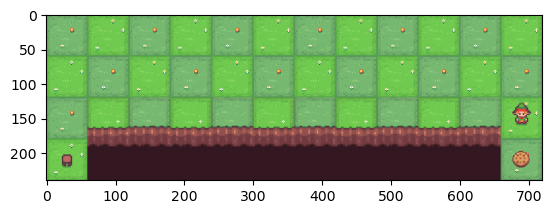

time: 3.47 s (started: 2023-11-19 11:44:45 +01:00)


In [81]:
from IPython.display import clear_output
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
# visualize policy
#current_policy = policies_10[8]
current_policy = policy
env = gym.make('CliffWalking-v0',render_mode='rgb_array')
env.reset()
for t in range(48):
    env.render()
    time.sleep(0.1)
    state, reward, done, _, _ = env.step(np.argmax(current_policy[state,:]))
    if done:
        break
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()


While not optimal, we have managed to estimate a policy that achieves our goal!